In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Reading in the dataset
skin_df = pd.read_csv('Skin_NonSkin.txt', sep='\s', names=['age','race','gender','labels']);
skin_df

<ipython-input-2-0549aac4a9f9>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  skin_df = pd.read_csv('Skin_NonSkin.txt', sep='\s', names=['age','race','gender','labels']);


,age,race,gender,labels
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1
...,...,...,...,...
245052,163,162,112,2
245053,163,162,112,2
245054,163,162,112,2
245055,163,162,112,2


In [3]:
# Checking if there are null values in the dataset
skin_df.isnull().values.any()

False

In [4]:
#One Hot Encoding
skin_cleaned_df = pd.get_dummies(skin_df['labels'])
skin_df['labels'] = skin_cleaned_df.loc[:,1];
skin_df

,age,race,gender,labels
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1
...,...,...,...,...
245052,163,162,112,0
245053,163,162,112,0
245054,163,162,112,0
245055,163,162,112,0


In [5]:
from sklearn.preprocessing import MinMaxScaler
#Scaling Continuous variables
scaler = MinMaxScaler()
skin_scaled_df = skin_df.copy()
skin_scaled_df[['age','race','gender']] = scaler.fit_transform(skin_scaled_df[['age','race','gender']])
skin_scaled_df

,age,race,gender,labels
0,0.290196,0.333333,0.482353,1
1,0.286275,0.329412,0.478431,1
2,0.282353,0.325490,0.474510,1
3,0.274510,0.317647,0.466667,1
4,0.274510,0.317647,0.466667,1
...,...,...,...,...
245052,0.639216,0.635294,0.439216,0
245053,0.639216,0.635294,0.439216,0
245054,0.639216,0.635294,0.439216,0
245055,0.639216,0.635294,0.439216,0


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

lg_accuracy_train = []
lg_roc_auc_train = []
lg_f1_train = []
lg_precision_train = []

lg_accuracy_test = []
lg_roc_auc_test = []
lg_f1_test = []
lg_precision_test = []

lg_Y_pred_list = []
lg_Y_test_list = []

C_val = [1e-8,1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

# 10 Trials
for i in range(10):
    #Random 5000 per trial
    skin_shuffle_df = skin_scaled_df.sample(frac = 1)
    
    #Train and Test set
    X_train,X_test = skin_shuffle_df.iloc[:5000,0:-1],skin_shuffle_df.iloc[5000:,0:-1]
    Y_train,Y_test = skin_shuffle_df.iloc[:5000,-1],skin_shuffle_df.iloc[5000:,-1]

    # Create a pipeline - RF is a stand in, we will populate the classifier part below
    pipe = Pipeline([('classifier', LogisticRegression())])

    # Create search space of candidate learning algorithms and their hyperparameters
    # note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
    search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': C_val},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','sag','newton-cg'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': C_val}
                ]

    # Create grid search 
    clf_lg = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc', 'f1','precision'], refit=False,
                   verbose=0,n_jobs=-1)

    # Fit grid search
    best_model = clf_lg.fit(X_train, Y_train)
    
    # Creating a Dataframe to contain the accuracy result per trial
    if i == 0:
        heat_results = pd.DataFrame( best_model.cv_results_['params'])
    # next grab the score resulting from those parameters, add it to the data
    # score is accuracy; to display it as misclassification error we use 1 - x   
    heat_results['score_acc_'+ str(i+1)] = 1 - best_model.cv_results_['mean_test_accuracy'] 
    # get rid of classifier__XX in columns
    cols = heat_results.columns.to_series().str.split('__').apply(lambda x: x[-1])
    heat_results.columns = cols
    
    # Getting the best classifiers
    best_acc_param = (best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy'])])
    best_roc_auc_param = (best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc'])])
    best_f1_param =(best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1'])])
    best_precision_param = (best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_precision'])])

    # Creating Logistical Regression based on best parameters
    acc_lg_1 = pipe.set_params(**best_acc_param)
    acc_lg = acc_lg_1.fit(X_train,Y_train) #Retrains on entire 5k samples
    print('LG_ACC Trial #',i,':',acc_lg.score(X_train,Y_train)) # Trainng Raw Scores On 5k Refitting
    lg_accuracy_train.append(acc_lg.score(X_train,Y_train))
    print('LG_ACC Test #',i,':',acc_lg.score(X_test,Y_test)) # Testing Scores
    lg_accuracy_test.append(acc_lg.score(X_test,Y_test))
    
    roc_auc_lg_1 = pipe.set_params(**best_roc_auc_param)
    roc_auc_lg = roc_auc_lg_1.fit(X_train,Y_train) #Retrains on entire 5k samples
    print('LG_ROC_AUC_OVR Trial #',i,':', roc_auc_score(Y_train,roc_auc_lg.predict_proba(X_train)[:,1])) # Trainng Raw Scores On 5k Refitting
    lg_roc_auc_train.append(roc_auc_score(Y_train,roc_auc_lg.predict_proba(X_train)[:,1]))
    print('LG_ROC_AUC Test #',i,':',roc_auc_score(Y_test,roc_auc_lg.predict_proba(X_test)[:,1])) # Testing Scores
    lg_roc_auc_test.append(roc_auc_score(Y_test,roc_auc_lg.predict_proba(X_test)[:,1]))
    
    #Roc Auc Curve https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
    #Appending each trial together to see the overall ROC curve
    lg_Y_pred_list.append(roc_auc_lg.predict_proba(X_test)[:,1])
    lg_Y_test_list.append(Y_test)
                             
                             
    f1_lg_1 = pipe.set_params(**best_f1_param)
    f1_lg = f1_lg_1.fit(X_train,Y_train) #Retrains on entire 5k samples                  
    print('LG_F1 Trial #',i,':', f1_score(Y_train,f1_lg.predict(X_train))) # Trainng Raw Scores On 5k Refitting
    lg_f1_train.append(f1_score(Y_train,f1_lg.predict(X_train)))                        
    print('LG_F1 Test #',i,':',f1_score(Y_test,f1_lg.predict(X_test))) # Testing Scores
    lg_f1_test.append(f1_score(Y_test,f1_lg.predict(X_test)))                             
                             
    precision_lg_1 =pipe.set_params(**best_precision_param)
    precision_lg =  precision_lg_1.fit(X_train,Y_train) #Retrains on entire 5k sample
    print('LG_Precision Trial #',i,':',average_precision_score(Y_train,precision_lg.predict(X_train))) # Trainng Raw Scores On 5k Refitting
    lg_precision_train.append(average_precision_score(Y_train,precision_lg.predict(X_train)))
    print('LG_Precision Test #',i,':',average_precision_score(Y_test,precision_lg.predict(X_test))) # Testing Scores
    lg_precision_test.append(average_precision_score(Y_test,precision_lg.predict(X_test)))             

LG_ACC Trial # 0 : 0.9178
LG_ACC Test # 0 : 0.919848202718521
LG_ROC_AUC_OVR Trial # 0 : 0.9521867892690322
LG_ROC_AUC Test # 0 : 0.9509652716645702
LG_F1 Trial # 0 : 0.802688430148824
LG_F1 Test # 0 : 0.8111132927547613
LG_Precision Trial # 0 : 0.6831872799859855
LG_Precision Test # 0 : 0.6936997837160914
LG_ACC Trial # 1 : 0.9216
LG_ACC Test # 1 : 0.9204272318657652
LG_ROC_AUC_OVR Trial # 1 : 0.9528422672224812
LG_ROC_AUC Test # 1 : 0.9542010074888598
LG_F1 Trial # 1 : 0.818686401480111
LG_F1 Test # 1 : 0.8119061450753733
LG_Precision Trial # 1 : 0.7006821831326746
LG_Precision Test # 1 : 0.6935296151586268
LG_ACC Trial # 2 : 0.918
LG_ACC Test # 2 : 0.915649199981671
LG_ROC_AUC_OVR Trial # 2 : 0.9539209868148997
LG_ROC_AUC Test # 2 : 0.951382241304464
LG_F1 Trial # 2 : 0.7988223748773308
LG_F1 Test # 2 : 0.8000710823271564
LG_Precision Trial # 2 : 0.6753658792041833
LG_Precision Test # 2 : 0.678113795871975
LG_ACC Trial # 3 : 0.913
LG_ACC Test # 3 : 0.9169572226596183
LG_ROC_AUC_OVR 

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

svm_accuracy_train = []
svm_roc_auc_train = []
svm_f1_train = []
svm_precision_train = []

svm_accuracy_test = []
svm_roc_auc_test = []
svm_f1_test = []
svm_precision_test = []

svm_Y_pred_list = []
svm_Y_test_list = []

C_val_svm = [1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]

# 10 Trials
for i in range(10):
    #Random 5000 per trial
    skin_shuffle_df = skin_scaled_df.sample(frac = 1)
    
    #Train and Test set
    X_train,X_test = skin_shuffle_df.iloc[:5000,0:-1],skin_shuffle_df.iloc[5000:,0:-1]
    Y_train,Y_test = skin_shuffle_df.iloc[:5000,-1],skin_shuffle_df.iloc[5000:,-1]

    # Create a pipeline - RF is a stand in, we will populate the classifier part below
    svm_pipe = Pipeline([('svm_classifier', SVC())])

    # Create search space of candidate learning algorithms and their hyperparameters
    # note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
    svm_search_space = [{'svm_classifier': [SVC()],
                 'svm_classifier__kernel': ['poly'],
                 'svm_classifier__degree': [2,3],
                 'svm_classifier__C': C_val_svm},
                {'svm_classifier': [SVC()],
                 'svm_classifier__kernel': ['linear'],
                 'svm_classifier__C': C_val_svm},
                {'svm_classifier': [SVC()],
                 'svm_classifier__kernel': ['rbf'],
                 'svm_classifier__gamma': [.001,.005,.01,.05,.1,.5,1,2],
                 'svm_classifier__C': C_val_svm}
                ]
        
    # Create grid search 
    clf_svm = GridSearchCV(svm_pipe, svm_search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc', 'f1','precision'], refit=False,
                   verbose=0,n_jobs=-1)

    # Fit grid search
    svm_best_model = clf_svm.fit(X_train, Y_train)
    
    #Creating a Dataframe to contain the accuracy result per trial
    if i == 0:
        svm_heat_results = pd.DataFrame( svm_best_model.cv_results_['params'] )
    # next grab the score resulting from those parameters, add it to the data
    # score is accuracy; to display it as misclassification error we use 1 - x   
    svm_heat_results['score_acc_'+ str(i+1)] = 1 - svm_best_model.cv_results_['mean_test_accuracy'] 
    # get rid of classifier__XX in columns
    cols = svm_heat_results.columns.to_series().str.split('__').apply(lambda x: x[-1])
    svm_heat_results.columns = cols
    
    # Getting the best classifiers
    best_acc_param = (svm_best_model.cv_results_['params'][ np.argmin(svm_best_model.cv_results_['rank_test_accuracy'])])
    best_roc_auc_param = (svm_best_model.cv_results_['params'][ np.argmin(svm_best_model.cv_results_['rank_test_roc_auc'])])
    best_f1_param =(svm_best_model.cv_results_['params'][ np.argmin(svm_best_model.cv_results_['rank_test_f1'])])
    best_precision_param = (svm_best_model.cv_results_['params'][ np.argmin(svm_best_model.cv_results_['rank_test_precision'])])

    # Creating Logistical Regression based on best parameters
    acc_svm_1 = svm_pipe.set_params(**best_acc_param)
    acc_svm = acc_svm_1.fit(X_train,Y_train) #Retrains on entire 5k samples
    print('SVM_ACC Trial #',i,':',acc_svm.score(X_train,Y_train)) # Trainng Raw Scores On 5k Refitting
    svm_accuracy_train.append(acc_svm.score(X_train,Y_train))
    print('SVM_ACC Test #',i,':',acc_svm.score(X_test,Y_test)) # Testing Scores
    svm_accuracy_test.append(acc_svm.score(X_test,Y_test))
    
    #https://stats.stackexchange.com/questions/254710/is-it-better-to-compute-a-roc-curve-using-predicted-probabilities-or-distances-f
    roc_auc_svm_1 = svm_pipe.set_params(**best_roc_auc_param)
    roc_auc_svm = roc_auc_svm_1.fit(X_train,Y_train) #Retrains on entire 5k samples
    print('SVM_ROC_AUC_OVR Trial #',i,':', roc_auc_score(Y_train,roc_auc_svm.decision_function(X_train))) # Trainng Raw Scores On 5k Refitting
    svm_roc_auc_train.append(roc_auc_score(Y_train,roc_auc_svm.decision_function(X_train)))
    print('SVM_ROC_AUC Test #',i,':',roc_auc_score(Y_test,roc_auc_svm.decision_function(X_test))) # Testing Scores
    svm_roc_auc_test.append(roc_auc_score(Y_test,roc_auc_svm.decision_function(X_test)))                            
                             
    #Roc Auc Curve https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
    svm_Y_pred_list.append(roc_auc_svm.decision_function(X_test))
    svm_Y_test_list.append(Y_test)
    
    f1_svm_1 = svm_pipe.set_params(**best_f1_param)
    f1_svm = f1_svm_1.fit(X_train,Y_train) #Retrains on entire 5k samples                  
    print('SVM_F1 Trial #',i,':', f1_score(Y_train,f1_svm.predict(X_train))) # Trainng Raw Scores On 5k Refitting
    svm_f1_train.append(f1_score(Y_train,f1_svm.predict(X_train)))                        
    print('SVM_F1 Test #',i,':',f1_score(Y_test,f1_svm.predict(X_test))) # Testing Scores
    svm_f1_test.append(f1_score(Y_test,f1_svm.predict(X_test)))                             
                             
    precision_svm_1 = svm_pipe.set_params(**best_precision_param)
    precision_svm =  precision_svm_1.fit(X_train,Y_train) #Retrains on entire 5k sample
    print('SVM_Precision Trial #',i,':',average_precision_score(Y_train,precision_svm.predict(X_train))) # Trainng Raw Scores On 5k Refitting
    svm_precision_train.append(average_precision_score(Y_train,precision_svm.predict(X_train)))
    print('SVM_Precision Test #',i,':',average_precision_score(Y_test,precision_svm.predict(X_test))) # Testing Scores
    svm_precision_test.append(average_precision_score(Y_test,precision_svm.predict(X_test)))  

SVM_ACC Trial # 0 : 0.9994
SVM_ACC Test # 0 : 0.9982129244304477
SVM_ROC_AUC_OVR Trial # 0 : 0.9998765492236689
SVM_ROC_AUC Test # 0 : 0.9998020440216573
SVM_F1 Trial # 0 : 0.998592210229939
SVM_F1 Test # 0 : 0.9957083262472364
SVM_Precision Trial # 0 : 0.9971883786316776
SVM_Precision Test # 0 : 0.9915695326501627
SVM_ACC Trial # 1 : 0.9992
SVM_ACC Test # 1 : 0.9981962617211746
SVM_ROC_AUC_OVR Trial # 1 : 0.9998033412878478
SVM_ROC_AUC Test # 1 : 0.9998321715874418
SVM_F1 Trial # 1 : 0.9980582524271845
SVM_F1 Test # 1 : 0.9956740231584627
SVM_Precision Trial # 1 : 0.9961240310077519
SVM_Precision Test # 1 : 0.9913893079332539
SVM_ACC Trial # 2 : 0.9986
SVM_ACC Test # 2 : 0.998050463015034
SVM_ROC_AUC_OVR Trial # 2 : 0.9998804405526516
SVM_ROC_AUC Test # 2 : 0.9998055147203221
SVM_F1 Trial # 2 : 0.9964806435394671
SVM_F1 Test # 2 : 0.9953290616204562
SVM_Precision Trial # 2 : 0.9969818913480886
SVM_Precision Test # 2 : 0.9923646016767305
SVM_ACC Trial # 3 : 0.9984
SVM_ACC Test # 3 : 0.

In [8]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

knn_accuracy_train = []
knn_roc_auc_train = []
knn_f1_train = []
knn_precision_train = []

knn_accuracy_test = []
knn_roc_auc_test = []
knn_f1_test = []
knn_precision_test = []

knn_Y_pred_list = []
knn_Y_test_list = []

K_Vals = np.linspace(1,105,26,dtype=int)
weights_list = ['uniform','distance']

# 10 Trials
for i in range(10):
    #Random 5000 per trial
    skin_shuffle_df = skin_scaled_df.sample(frac = 1)
    
    #Train and Test set
    X_train,X_test = skin_shuffle_df.iloc[:5000,0:-1],skin_shuffle_df.iloc[5000:,0:-1]
    Y_train,Y_test = skin_shuffle_df.iloc[:5000,-1],skin_shuffle_df.iloc[5000:,-1]

    # Create a pipeline - RF is a stand in, we will populate the classifier part below
    # https://stackoverflow.com/questions/34889110/random-forest-with-gridsearchcv-error-on-param-grid
    knn_pipe = Pipeline([('knn_classifier', KNeighborsClassifier())])

    # Create search space of candidate learning algorithms and their hyperparameters
    # note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
    knn_param = {'knn_classifier':[KNeighborsClassifier()],
                 'knn_classifier__n_neighbors':K_Vals,
                 'knn_classifier__weights':weights_list,
                 'knn_classifier__metric':['euclidean']}
        
    # Create grid search 
    clf_knn = GridSearchCV(knn_pipe, knn_param, cv=StratifiedKFold(n_splits=5), 
                           scoring=['accuracy', 'roc_auc', 'f1','precision'], refit=False,
                           verbose=0,n_jobs=-1)

    # Fit grid search
    knn_best_model = clf_knn.fit(X_train, Y_train)
    
    #Creating a Dataframe to contain the accuracy result per trial
    if i == 0:
        knn_heat_results = pd.DataFrame( knn_best_model.cv_results_['params'] )
    # next grab the score resulting from those parameters, add it to the data
    # score is accuracy; to display it as misclassification error we use 1 - x   
    knn_heat_results['score_acc_'+ str(i+1)] = 1 - knn_best_model.cv_results_['mean_test_accuracy'] 
    # get rid of classifier__XX in columns
    cols = knn_heat_results.columns.to_series().str.split('__').apply(lambda x: x[-1])
    knn_heat_results.columns = cols
    
    # Getting the best classifiers
    best_acc_param = (knn_best_model.cv_results_['params'][ np.argmin(knn_best_model.cv_results_['rank_test_accuracy'])])
    best_roc_auc_param = (knn_best_model.cv_results_['params'][ np.argmin(knn_best_model.cv_results_['rank_test_roc_auc'])])
    best_f1_param =(knn_best_model.cv_results_['params'][ np.argmin(knn_best_model.cv_results_['rank_test_f1'])])
    best_precision_param = (knn_best_model.cv_results_['params'][ np.argmin(knn_best_model.cv_results_['rank_test_precision'])])
    
    # Creating KNN based on best parameters
    acc_knn_1 = knn_pipe.set_params(**best_acc_param)
    acc_knn = acc_knn_1.fit(X_train,Y_train) #Retrains on entire 5k samples
    print('KNN_ACC Trial #',i,':',acc_knn.score(X_train,Y_train)) # Trainng Raw Scores On 5k Refitting
    knn_accuracy_train.append(acc_knn.score(X_train,Y_train))
    print('KNN_ACC Test #',i,':',acc_knn.score(X_test,Y_test)) # Testing Scores
    knn_accuracy_test.append(acc_knn.score(X_test,Y_test))
    
    roc_auc_knn_1 = knn_pipe.set_params(**best_roc_auc_param)
    roc_auc_knn = roc_auc_knn_1.fit(X_train,Y_train) #Retrains on entire 5k samples
    print('KNN_ROC_AUC_OVR Trial #',i,':', roc_auc_score(Y_train,roc_auc_knn.predict_proba(X_train)[:,1])) # Trainng Raw Scores On 5k Refitting
    knn_roc_auc_train.append(roc_auc_score(Y_train,roc_auc_knn.predict_proba(X_train)[:,1]))
    print('KNN_ROC_AUC Test #',i,':',roc_auc_score(Y_test,roc_auc_knn.predict_proba(X_test)[:,1])) # Testing Scores
    knn_roc_auc_test.append(roc_auc_score(Y_test,roc_auc_knn.predict_proba(X_test)[:,1]))                            
    
    #Roc Auc Curve https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
    knn_Y_pred_list.append(roc_auc_knn.predict_proba(X_test)[:,1])
    knn_Y_test_list.append(Y_test) 
                             
    f1_knn_1 = knn_pipe.set_params(**best_f1_param)
    f1_knn = f1_knn_1.fit(X_train,Y_train) #Retrains on entire 5k samples                  
    print('KNN_F1 Trial #',i,':', f1_score(Y_train,f1_knn.predict(X_train))) # Trainng Raw Scores On 5k Refitting
    knn_f1_train.append(f1_score(Y_train,f1_knn.predict(X_train)))                        
    print('KNN_F1 Test #',i,':',f1_score(Y_test,f1_knn.predict(X_test))) # Testing Scores
    knn_f1_test.append(f1_score(Y_test,f1_knn.predict(X_test)))                             
                             
    precision_knn_1 = knn_pipe.set_params(**best_precision_param)
    precision_knn =  precision_knn_1.fit(X_train,Y_train) #Retrains on entire 5k sample
    print('KNN_Precision Trial #',i,':',average_precision_score(Y_train,precision_knn.predict(X_train))) # Trainng Raw Scores On 5k Refitting
    knn_precision_train.append(average_precision_score(Y_train,precision_knn.predict(X_train)))
    print('KNN_Precision Test #',i,':',average_precision_score(Y_test,precision_knn.predict(X_test))) # Testing Scores
    knn_precision_test.append(average_precision_score(Y_test,precision_knn.predict(X_test)))
  

KNN_ACC Trial # 0 : 1.0
KNN_ACC Test # 0 : 0.9983462261046335
KNN_ROC_AUC_OVR Trial # 0 : 1.0
KNN_ROC_AUC Test # 0 : 0.9995484395030693
KNN_F1 Trial # 0 : 1.0
KNN_F1 Test # 0 : 0.9960251108863902
KNN_Precision Trial # 0 : 1.0
KNN_Precision Test # 0 : 0.9924496953006765
KNN_ACC Trial # 1 : 1.0
KNN_ACC Test # 1 : 0.9984836934561375
KNN_ROC_AUC_OVR Trial # 1 : 1.0
KNN_ROC_AUC Test # 1 : 0.9997631638525789
KNN_F1 Trial # 1 : 1.0
KNN_F1 Test # 1 : 0.9963532169835895
KNN_Precision Trial # 1 : 1.0
KNN_Precision Test # 1 : 0.9930244844711141
KNN_ACC Trial # 2 : 1.0
KNN_ACC Test # 2 : 0.9980837884335804
KNN_ROC_AUC_OVR Trial # 2 : 1.0
KNN_ROC_AUC Test # 2 : 0.9993720045667861
KNN_F1 Trial # 2 : 1.0
KNN_F1 Test # 2 : 0.995408356790641
KNN_Precision Trial # 2 : 1.0
KNN_Precision Test # 2 : 0.9908905846430491
KNN_ACC Trial # 3 : 1.0
KNN_ACC Test # 3 : 0.9986294921622781
KNN_ROC_AUC_OVR Trial # 3 : 1.0
KNN_ROC_AUC Test # 3 : 0.9998065941252339
KNN_F1 Trial # 3 : 1.0
KNN_F1 Test # 3 : 0.996708189504

In [9]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

dt_accuracy_train = []
dt_roc_auc_train = []
dt_f1_train = []
dt_precision_train = []

dt_accuracy_test = []
dt_roc_auc_test = []
dt_f1_test = []
dt_precision_test = []

dt_Y_pred_list = []
dt_Y_test_list = []

# 10 Trials
for i in range(10):
    #Random 5000 per trial
    skin_shuffle_df = skin_scaled_df.sample(frac = 1)
    
    #Train and Test set
    X_train,X_test = skin_shuffle_df.iloc[:5000,0:-1],skin_shuffle_df.iloc[5000:,0:-1]
    Y_train,Y_test = skin_shuffle_df.iloc[:5000,-1],skin_shuffle_df.iloc[5000:,-1]


    # https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
    # Create a pipeline - RF is a stand in, we will populate the classifier part below
    # https://stackoverflow.com/questions/34889110/random-forest-with-gridsearchcv-error-on-param-grid
    dt_pipe = Pipeline([('dt_classifier', DecisionTreeClassifier())])

    # Create search space of candidate learning algorithms and their hyperparameters
    # note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
    dt_param = {'dt_classifier':[DecisionTreeClassifier()],
                 'dt_classifier__criterion': ['gini','entropy'],
                 'dt_classifier__ccp_alpha': [.000,.005,.010,.015,.020,.030,.035],
                 'dt_classifier__max_depth':[1,2,3,4,5,6,7,8,9],
               }
    #Locally weighted not necessary - EC
    #Radius Neighbors classifier - EC
    
    # Create grid search 
    clf_dt = GridSearchCV(dt_pipe, dt_param, cv=StratifiedKFold(n_splits=5), 
                           scoring=['accuracy', 'roc_auc', 'f1','precision'], refit=False,
                           verbose=0,n_jobs=-1)

    # Fit grid search
    dt_best_model = clf_dt.fit(X_train, Y_train)
  
    #Creating a Dataframe to contain the accuracy result per trial
    if i == 0:
        dt_heat_results = pd.DataFrame( dt_best_model.cv_results_['params'] )
    # next grab the score resulting from those parameters, add it to the data
    # score is accuracy; to display it as misclassification error we use 1 - x   
    dt_heat_results['score_acc_'+ str(i+1)] = 1 - dt_best_model.cv_results_['mean_test_accuracy'] 
    # get rid of classifier__XX in columns
    cols = dt_heat_results.columns.to_series().str.split('__').apply(lambda x: x[-1])
    dt_heat_results.columns = cols
    
    # Getting the best classifiers
    best_acc_param = (dt_best_model.cv_results_['params'][ np.argmin(dt_best_model.cv_results_['rank_test_accuracy'])])
    best_roc_auc_param = (dt_best_model.cv_results_['params'][ np.argmin(dt_best_model.cv_results_['rank_test_roc_auc'])])
    best_f1_param =(dt_best_model.cv_results_['params'][ np.argmin(dt_best_model.cv_results_['rank_test_f1'])])
    best_precision_param = (dt_best_model.cv_results_['params'][ np.argmin(dt_best_model.cv_results_['rank_test_precision'])])
    
    # Creating DT based on best parameters
    acc_dt_1 = dt_pipe.set_params(**best_acc_param)
    acc_dt = acc_dt_1.fit(X_train,Y_train) #Retrains on entire 5k samples
    print('DT_ACC Trial #',i,':',acc_dt.score(X_train,Y_train)) # Trainng Raw Scores On 5k Refitting
    dt_accuracy_train.append(acc_dt.score(X_train,Y_train))
    print('DT_ACC Test #',i,':',acc_dt.score(X_test,Y_test)) # Testing Scores
    dt_accuracy_test.append(acc_dt.score(X_test,Y_test))
    
    roc_auc_dt_1 = dt_pipe.set_params(**best_roc_auc_param)
    roc_auc_dt = roc_auc_dt_1.fit(X_train,Y_train) #Retrains on entire 5k samples
    print('DT_ROC_AUC_OVR Trial #',i,':', roc_auc_score(Y_train,roc_auc_dt.predict_proba(X_train)[:,1])) # Trainng Raw Scores On 5k Refitting
    dt_roc_auc_train.append(roc_auc_score(Y_train,roc_auc_dt.predict_proba(X_train)[:,1]))
    print('DT_ROC_AUC Test #',i,':',roc_auc_score(Y_test,roc_auc_dt.predict_proba(X_test)[:,1])) # Testing Scores
    dt_roc_auc_test.append(roc_auc_score(Y_test,roc_auc_dt.predict_proba(X_test)[:,1]))                            
                             
    #Roc Auc Curve https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
    dt_Y_pred_list.append(roc_auc_dt.predict_proba(X_test)[:,1])
    dt_Y_test_list.append(Y_test) 
    
    f1_dt_1 = dt_pipe.set_params(**best_f1_param)
    f1_dt = f1_dt_1.fit(X_train,Y_train) #Retrains on entire 5k samples                  
    print('DT_F1 Trial #',i,':', f1_score(Y_train,f1_dt.predict(X_train))) # Trainng Raw Scores On 5k Refitting
    dt_f1_train.append(f1_score(Y_train,f1_dt.predict(X_train)))                        
    print('DT_F1 Test #',i,':',f1_score(Y_test,f1_dt.predict(X_test))) # Testing Scores
    dt_f1_test.append(f1_score(Y_test,f1_dt.predict(X_test)))                             
                             
    precision_dt_1 = dt_pipe.set_params(**best_precision_param)
    precision_dt =  precision_dt_1.fit(X_train,Y_train) #Retrains on entire 5k sample
    print('DT_Precision Trial #',i,':',average_precision_score(Y_train,precision_dt.predict(X_train))) # Trainng Raw Scores On 5k Refitting
    dt_precision_train.append(average_precision_score(Y_train,precision_dt.predict(X_train)))
    print('DT_Precision Test #',i,':',average_precision_score(Y_test,precision_dt.predict(X_test))) # Testing Scores
    dt_precision_test.append(average_precision_score(Y_test,precision_dt.predict(X_test)))

DT_ACC Trial # 0 : 0.9994
DT_ACC Test # 0 : 0.9946304419367067
DT_ROC_AUC_OVR Trial # 0 : 0.9999050161067649
DT_ROC_AUC Test # 0 : 0.9949457644778962
DT_F1 Trial # 0 : 0.9985387238188017
DT_F1 Test # 0 : 0.9871825491600987
DT_Precision Trial # 0 : 0.9970817120622568
DT_Precision Test # 0 : 0.976119155869922
DT_ACC Trial # 1 : 0.9978
DT_ACC Test # 1 : 0.9935890226071308
DT_ROC_AUC_OVR Trial # 1 : 0.9994125722620053
DT_ROC_AUC Test # 1 : 0.9921079166800372
DT_F1 Trial # 1 : 0.9951076320939334
DT_F1 Test # 1 : 0.9859500913693419
DT_Precision Trial # 1 : 0.9892996108949417
DT_Precision Test # 1 : 0.9717260248466693
DT_ACC Trial # 2 : 0.997
DT_ACC Test # 2 : 0.9939472708565049
DT_ROC_AUC_OVR Trial # 2 : 0.9983501261985986
DT_ROC_AUC Test # 2 : 0.9950858669575232
DT_F1 Trial # 2 : 0.9929211892402077
DT_F1 Test # 2 : 0.9853828375904193
DT_Precision Trial # 2 : 0.9867032469568688
DT_Precision Test # 2 : 0.9733755255479676
DT_ACC Trial # 3 : 0.9968
DT_ACC Test # 3 : 0.9932640997763031
DT_ROC_AU

In [10]:
# Creating Arrays to hold mean metric for each trial
# Logistic Regression
lg_accuracy_train
lg_roc_auc_train
lg_f1_train
lg_precision_train

lg_accuracy_test
lg_roc_auc_test
lg_f1_test
lg_precision_test

# SVM
svm_accuracy_train
svm_roc_auc_train
svm_f1_train
svm_precision_train

svm_accuracy_test
svm_roc_auc_test
svm_f1_test
svm_precision_test

#KNN
knn_accuracy_train
knn_roc_auc_train
knn_f1_train
knn_precision_train

knn_accuracy_test
knn_roc_auc_test
knn_f1_test
knn_precision_test

#DT
dt_accuracy_train
dt_roc_auc_train
dt_f1_train
dt_precision_train

dt_accuracy_test
dt_roc_auc_test
dt_f1_test
dt_precision_test

[0.976119155869922,
 0.9717260248466693,
 0.9733755255479676,
 0.9714068961661732,
 0.9673468837023574,
 0.9750220636095378,
 0.9721511060549883,
 0.9614432357052771,
 0.9703401672371046,
 0.9712744849956924]

In [11]:
Training_List = [lg_accuracy_train,svm_accuracy_train,knn_accuracy_train,dt_accuracy_train,lg_roc_auc_train,svm_roc_auc_train,knn_roc_auc_train,dt_roc_auc_train,lg_f1_train,svm_f1_train,knn_f1_train,dt_f1_train,lg_precision_train,svm_precision_train,knn_precision_train,dt_precision_train]

In [12]:
Training_Results = pd.DataFrame(Training_List, index=['LG_ACC','SVM_ACC','KNN_ACC','DT_ACC','LG_ROC_AUC','SVM_ROC_AUC','KNN_ROC_AUC','DT_ROC_AUC','LG_F1','SVM_F1','KNN_F1','DT_F1','LG_PRECISION','SVM_PRECISION','KNN_PRECISION','DT_PRECISION'],
                                columns=['Training_Trial_1','Training_Trial_2','Training_Trial_3','Training_Trial_4','Training_Trial_5','Training_Trial_6','Training_Trial_7','Training_Trial_8','Training_Trial_9','Training_Trial_10'])
Training_Results.to_csv("skin_training_FINAL.csv")
Training_Results['Training_MEAN'] = Training_Results.mean(axis=1)
Training_Results

,Training_Trial_1,Training_Trial_2,Training_Trial_3,Training_Trial_4,Training_Trial_5,Training_Trial_6,Training_Trial_7,Training_Trial_8,Training_Trial_9,Training_Trial_10,Training_MEAN
LG_ACC,0.917800,0.921600,0.918000,0.913000,0.911800,0.916000,0.915400,0.927600,0.919600,0.924400,0.918520
SVM_ACC,0.999400,0.999200,0.998600,0.998400,0.999200,0.998000,0.997400,0.999000,0.998600,0.998400,0.998620
KNN_ACC,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
DT_ACC,0.999400,0.997800,0.997000,0.996800,0.996800,0.998400,0.996400,0.998000,0.996800,0.998600,0.997600
LG_ROC_AUC,0.952187,0.952842,0.953921,0.948523,0.950369,0.951529,0.949470,0.958143,0.956063,0.953817,0.952686
SVM_ROC_AUC,0.999877,0.999803,0.999880,0.999854,0.999790,0.999610,0.999757,0.999999,0.999953,0.999905,0.999843
KNN_ROC_AUC,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
DT_ROC_AUC,0.999905,0.999413,0.998350,0.996793,0.999225,0.999635,0.999400,0.999257,0.999360,0.999543,0.999088
LG_F1,0.802688,0.818686,0.798822,0.778174,0.785192,0.799043,0.803894,0.825962,0.815087,0.818618,0.804617
SVM_F1,0.998592,0.998058,0.996481,0.996055,0.998197,0.995127,0.993818,0.997595,0.996600,0.996340,0.996686


In [13]:
Testing_List = [lg_accuracy_test,svm_accuracy_test,knn_accuracy_test,dt_accuracy_test,lg_roc_auc_test,svm_roc_auc_test,knn_roc_auc_test,dt_roc_auc_test,lg_f1_test,svm_f1_test,knn_f1_test,dt_f1_test,lg_precision_test,svm_precision_test,knn_precision_test,dt_precision_test]

In [14]:
Testing_Results = pd.DataFrame(Testing_List, index=['LG_ACC','SVM_ACC','KNN_ACC','DT_ACC','LG_ROC_AUC','SVM_ROC_AUC','KNN_ROC_AUC','DT_ROC_AUC','LG_F1','SVM_F1','KNN_F1','DT_F1','LG_PRECISION','SVM_PRECISION','KNN_PRECISION','DT_PRECISION'],
                               columns=['Test_Trial_1','Test_Trial_2','Test_Trial_3','Test_Trial_4','Test_Trial_5','Test_Trial_6','Test_Trial_7','Test_Trial_8','Test_Trial_9','Test_Trial_10'])
Testing_Results.to_csv("skin_testing_FINAL.csv")
Testing_Results['Test_MEAN'] = Testing_Results.mean(axis=1)
Testing_Results

,Test_Trial_1,Test_Trial_2,Test_Trial_3,Test_Trial_4,Test_Trial_5,Test_Trial_6,Test_Trial_7,Test_Trial_8,Test_Trial_9,Test_Trial_10,Test_MEAN
LG_ACC,0.919848,0.920427,0.915649,0.916957,0.918532,0.917799,0.921406,0.917590,0.919877,0.921094,0.918918
SVM_ACC,0.998213,0.998196,0.998050,0.998421,0.998505,0.998459,0.998105,0.997930,0.998192,0.998146,0.998222
KNN_ACC,0.998346,0.998484,0.998084,0.998629,0.998021,0.998475,0.997821,0.998450,0.998638,0.998334,0.998328
DT_ACC,0.994630,0.993589,0.993947,0.993264,0.993152,0.994460,0.993622,0.991256,0.993027,0.993647,0.993459
LG_ROC_AUC,0.950965,0.954201,0.951382,0.952614,0.952335,0.953071,0.949895,0.953353,0.954297,0.948367,0.952048
SVM_ROC_AUC,0.999802,0.999832,0.999806,0.999875,0.999733,0.999856,0.999863,0.999738,0.999832,0.999830,0.999817
KNN_ROC_AUC,0.999548,0.999763,0.999372,0.999807,0.999341,0.999768,0.999438,0.999619,0.999493,0.999515,0.999566
DT_ROC_AUC,0.994946,0.992108,0.995086,0.994498,0.994385,0.992390,0.994653,0.993099,0.993802,0.994904,0.993987
LG_F1,0.811113,0.811906,0.800071,0.802195,0.806953,0.804942,0.815600,0.805011,0.811247,0.815080,0.808412
SVM_F1,0.995708,0.995674,0.995329,0.996212,0.996403,0.996297,0.995453,0.995037,0.995664,0.995549,0.995733


In [15]:
from scipy import stats
stats.ttest_ind(lg_accuracy_train,svm_accuracy_train)

Ttest_indResult(statistic=-50.82121748057554, pvalue=6.778406918507485e-21)

,classifier,C,penalty,solver,score_acc_1,score_acc_2,score_acc_3,score_acc_4,score_acc_5,score_acc_6,score_acc_7,score_acc_8,score_acc_9,score_acc_10,mean_score_acc
0,"LogisticRegression(C=100.0, max_iter=5000, pen...",1.000000e-08,l1,saga,0.2060,0.2094,0.2016,0.1912,0.2018,0.2050,0.213,0.2024,0.2130,0.2050,0.20484
1,"LogisticRegression(C=100.0, max_iter=5000, pen...",1.000000e-08,l2,saga,0.2060,0.2094,0.2016,0.1912,0.2018,0.2050,0.213,0.2024,0.2130,0.2050,0.20484
2,"LogisticRegression(C=100.0, max_iter=5000, pen...",1.000000e-07,l1,saga,0.2060,0.2094,0.2016,0.1912,0.2018,0.2050,0.213,0.2024,0.2130,0.2050,0.20484
3,"LogisticRegression(C=100.0, max_iter=5000, pen...",1.000000e-07,l2,saga,0.2060,0.2094,0.2016,0.1912,0.2018,0.2050,0.213,0.2024,0.2130,0.2050,0.20484
4,"LogisticRegression(C=100.0, max_iter=5000, pen...",1.000000e-06,l1,saga,0.2060,0.2094,0.2016,0.1912,0.2018,0.2050,0.213,0.2024,0.2130,0.2050,0.20484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,LogisticRegression(max_iter=5000),1.000000e+03,l2,sag,0.0822,0.0782,0.0810,0.0870,0.0884,0.0836,0.085,0.0718,0.0796,0.0762,0.08130
61,LogisticRegression(max_iter=5000),1.000000e+03,l2,newton-cg,0.0822,0.0782,0.0810,0.0870,0.0884,0.0836,0.085,0.0718,0.0796,0.0762,0.08130
62,LogisticRegression(max_iter=5000),1.000000e+04,l2,lbfgs,0.0822,0.0782,0.0810,0.0870,0.0884,0.0836,0.085,0.0718,0.0796,0.0762,0.08130
63,LogisticRegression(max_iter=5000),1.000000e+04,l2,sag,0.0822,0.0782,0.0810,0.0870,0.0884,0.0836,0.085,0.0718,0.0796,0.0762,0.08130


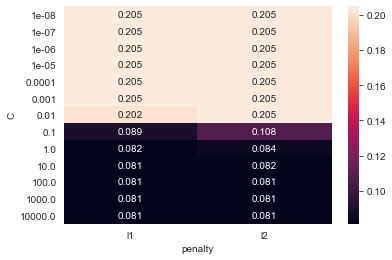

In [16]:
import seaborn as sns; sns.set_style('white')  # plot formatting
# Taking the average of the 5 trials to create 1 heat map based on the averages
heat_results['mean_score_acc'] = heat_results.loc[:,['score_acc_1','score_acc_2','score_acc_3','score_acc_4','score_acc_5','score_acc_6','score_acc_7','score_acc_8','score_acc_9','score_acc_10']].mean(axis=1)

# lets show the results for the saga solver across penalty & C values
sns.heatmap( heat_results.query('solver=="saga"').pivot('C','penalty','mean_score_acc'),
             annot=True, fmt='.3f')
heat_results

,svm_classifier,C,degree,kernel,gamma,score_acc_1,score_acc_2,score_acc_3,score_acc_4,score_acc_5,score_acc_6,score_acc_7,score_acc_8,score_acc_9,score_acc_10,mean_score_acc
0,SVC(),1.000000e-07,2.0,poly,NaN,0.2128,0.2056,0.1982,0.2020,0.2214,0.2042,0.2090,0.2074,0.2052,0.2180,0.20838
1,SVC(),1.000000e-07,3.0,poly,NaN,0.2128,0.2056,0.1982,0.2020,0.2214,0.2042,0.2090,0.2074,0.2052,0.2180,0.20838
2,SVC(),1.000000e-06,2.0,poly,NaN,0.2128,0.2056,0.1982,0.2020,0.2214,0.2042,0.2090,0.2074,0.2052,0.2180,0.20838
3,SVC(),1.000000e-06,3.0,poly,NaN,0.2128,0.2056,0.1982,0.2020,0.2214,0.2042,0.2090,0.2074,0.2052,0.2180,0.20838
4,SVC(),1.000000e-05,2.0,poly,NaN,0.2128,0.2056,0.1982,0.2020,0.2214,0.2042,0.2090,0.2074,0.2052,0.2180,0.20838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,"SVC(C=1000.0, gamma=2)",1.000000e+03,NaN,rbf,0.05,0.0134,0.0134,0.0160,0.0130,0.0130,0.0144,0.0142,0.0120,0.0140,0.0106,0.01340
117,"SVC(C=1000.0, gamma=2)",1.000000e+03,NaN,rbf,0.10,0.0096,0.0084,0.0116,0.0092,0.0088,0.0096,0.0106,0.0094,0.0126,0.0080,0.00978
118,"SVC(C=1000.0, gamma=2)",1.000000e+03,NaN,rbf,0.50,0.0046,0.0060,0.0056,0.0042,0.0054,0.0058,0.0062,0.0054,0.0068,0.0048,0.00548
119,"SVC(C=1000.0, gamma=2)",1.000000e+03,NaN,rbf,1.00,0.0024,0.0016,0.0018,0.0038,0.0024,0.0048,0.0032,0.0012,0.0018,0.0032,0.00262


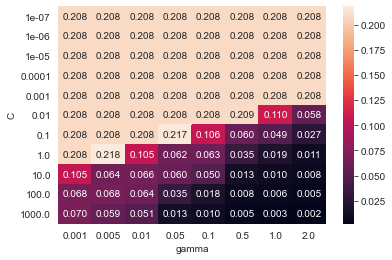

In [17]:
svm_heat_results['mean_score_acc'] = svm_heat_results.loc[:,['score_acc_1','score_acc_2','score_acc_3','score_acc_4','score_acc_5','score_acc_6','score_acc_7','score_acc_8','score_acc_9','score_acc_10']].mean(axis=1)

# lets show the results for the saga solver across penalty & C values
sns.heatmap( svm_heat_results.query('kernel=="rbf"').pivot('C','gamma','mean_score_acc'),
             annot=True, fmt='.3f')
svm_heat_results

,knn_classifier,metric,n_neighbors,weights,score_acc_1,score_acc_2,score_acc_3,score_acc_4,score_acc_5,score_acc_6,score_acc_7,score_acc_8,score_acc_9,score_acc_10,mean_score_acc
0,"KNeighborsClassifier(metric='euclidean', n_nei...",euclidean,1,uniform,0.0016,0.0022,0.0020,0.0022,0.0012,0.0028,0.0012,0.0018,0.0024,0.0012,0.00186
1,"KNeighborsClassifier(metric='euclidean', n_nei...",euclidean,1,distance,0.0016,0.0022,0.0020,0.0022,0.0012,0.0028,0.0012,0.0018,0.0024,0.0012,0.00186
2,"KNeighborsClassifier(metric='euclidean', n_nei...",euclidean,5,uniform,0.0040,0.0038,0.0032,0.0026,0.0028,0.0034,0.0020,0.0030,0.0030,0.0036,0.00314
3,"KNeighborsClassifier(metric='euclidean', n_nei...",euclidean,5,distance,0.0032,0.0036,0.0024,0.0026,0.0020,0.0030,0.0016,0.0028,0.0026,0.0028,0.00266
4,"KNeighborsClassifier(metric='euclidean', n_nei...",euclidean,9,uniform,0.0070,0.0064,0.0046,0.0058,0.0046,0.0046,0.0030,0.0048,0.0058,0.0042,0.00508
5,"KNeighborsClassifier(metric='euclidean', n_nei...",euclidean,9,distance,0.0038,0.0046,0.0028,0.0036,0.0022,0.0038,0.0022,0.0038,0.0040,0.0034,0.00342
6,"KNeighborsClassifier(metric='euclidean', n_nei...",euclidean,13,uniform,0.0098,0.0072,0.0056,0.0078,0.0060,0.0066,0.0050,0.0054,0.0074,0.0046,0.00654
7,"KNeighborsClassifier(metric='euclidean', n_nei...",euclidean,13,distance,0.0044,0.0050,0.0036,0.0050,0.0028,0.0044,0.0026,0.0042,0.0048,0.0038,0.00406
8,"KNeighborsClassifier(metric='euclidean', n_nei...",euclidean,17,uniform,0.0110,0.0088,0.0068,0.0092,0.0080,0.0088,0.0072,0.0076,0.0088,0.0084,0.00846
9,"KNeighborsClassifier(metric='euclidean', n_nei...",euclidean,17,distance,0.0064,0.0056,0.0042,0.0052,0.0034,0.0050,0.0028,0.0042,0.0054,0.0042,0.00464


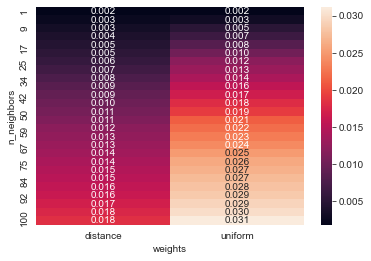

In [18]:
knn_heat_results['mean_score_acc'] = knn_heat_results.loc[:,['score_acc_1','score_acc_2','score_acc_3','score_acc_4','score_acc_5','score_acc_6','score_acc_7','score_acc_8','score_acc_9','score_acc_10']].mean(axis=1)

# lets show the results for the saga solver across penalty & C values
sns.heatmap( knn_heat_results.pivot('n_neighbors','weights','mean_score_acc'),
             annot=True, fmt='.3f')
knn_heat_results

,dt_classifier,ccp_alpha,criterion,max_depth,score_acc_1,score_acc_2,score_acc_3,score_acc_4,score_acc_5,score_acc_6,score_acc_7,score_acc_8,score_acc_9,score_acc_10,mean_score_acc
0,"DecisionTreeClassifier(criterion='entropy', ma...",0.000,gini,1,0.1188,0.1142,0.1232,0.1258,0.1146,0.1148,0.1208,0.1258,0.1144,0.1234,0.11958
1,"DecisionTreeClassifier(criterion='entropy', ma...",0.000,gini,2,0.0932,0.0978,0.1010,0.0994,0.0882,0.0904,0.0966,0.0980,0.0948,0.0958,0.09552
2,"DecisionTreeClassifier(criterion='entropy', ma...",0.000,gini,3,0.0402,0.0416,0.0390,0.0396,0.0298,0.0342,0.0366,0.0388,0.0360,0.0318,0.03676
3,"DecisionTreeClassifier(criterion='entropy', ma...",0.000,gini,4,0.0320,0.0270,0.0296,0.0314,0.0258,0.0262,0.0278,0.0272,0.0260,0.0218,0.02748
4,"DecisionTreeClassifier(criterion='entropy', ma...",0.000,gini,5,0.0200,0.0182,0.0200,0.0200,0.0152,0.0190,0.0182,0.0154,0.0188,0.0196,0.01844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,"DecisionTreeClassifier(criterion='entropy', ma...",0.035,gini,5,0.1188,0.1142,0.0910,0.0842,0.0764,0.0858,0.0826,0.1054,0.1144,0.0844,0.09572
113,"DecisionTreeClassifier(criterion='entropy', ma...",0.035,gini,6,0.1188,0.1142,0.0910,0.0842,0.0764,0.0858,0.0826,0.1054,0.1144,0.0844,0.09572
114,"DecisionTreeClassifier(criterion='entropy', ma...",0.035,gini,7,0.1188,0.1142,0.0910,0.0842,0.0764,0.0858,0.0826,0.1054,0.1144,0.0844,0.09572
115,"DecisionTreeClassifier(criterion='entropy', ma...",0.035,gini,8,0.1188,0.1142,0.0910,0.0842,0.0764,0.0858,0.0826,0.1054,0.1144,0.0844,0.09572


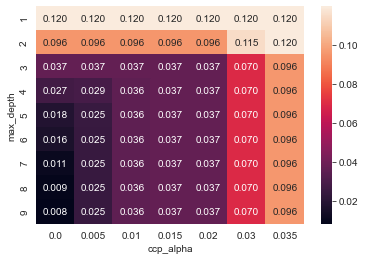

In [19]:
dt_heat_results['mean_score_acc'] = dt_heat_results.loc[:,['score_acc_1','score_acc_2','score_acc_3','score_acc_4','score_acc_5','score_acc_6','score_acc_7','score_acc_8','score_acc_9','score_acc_10']].mean(axis=1)

# lets show the results for the saga solver across penalty & C values
dt_cleaned = dt_heat_results.drop_duplicates(['max_depth','ccp_alpha'])
sns.heatmap( dt_cleaned.pivot('max_depth','ccp_alpha','mean_score_acc'),
             annot=True, fmt='.3f')
dt_cleaned

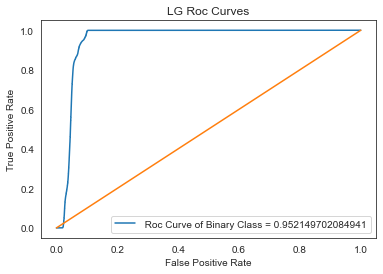

In [20]:
#https://datascience.stackexchange.com/questions/69442/plotting-roc-auc-for-svm-algorithm
from sklearn.metrics import roc_curve, auc
# Concating the list together
lg_Y_test = pd.concat(lg_Y_test_list)
lg_Y_pred = np.concatenate(lg_Y_pred_list)
# Getting the Roc Curve values
test_fpr, test_tpr, test_thresholds = roc_curve(lg_Y_test,lg_Y_pred)
plt.plot(test_fpr, test_tpr, label=" Roc Curve of Binary Class = "+ str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1])
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LG Roc Curves")
plt.show()

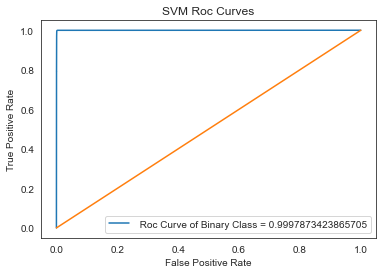

In [21]:
# Concating the list together
svm_Y_test = pd.concat(svm_Y_test_list)
svm_Y_pred = np.concatenate(svm_Y_pred_list)
# Getting the Roc Curve values
test_fpr, test_tpr, test_thresholds = roc_curve(svm_Y_test,svm_Y_pred)
plt.plot(test_fpr, test_tpr, label=" Roc Curve of Binary Class = "+ str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1])
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM Roc Curves")
plt.show()

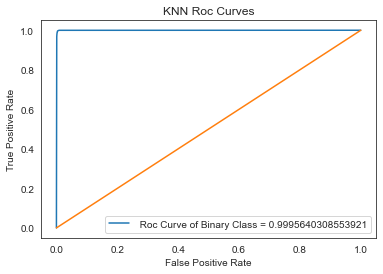

In [22]:
# Concating the list together
knn_Y_test = pd.concat(knn_Y_test_list)
knn_Y_pred = np.concatenate(knn_Y_pred_list)
# Getting the Roc Curve values
test_fpr, test_tpr, test_thresholds = roc_curve(knn_Y_test,knn_Y_pred)
plt.plot(test_fpr, test_tpr, label=" Roc Curve of Binary Class = "+ str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1])
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN Roc Curves")
plt.show()

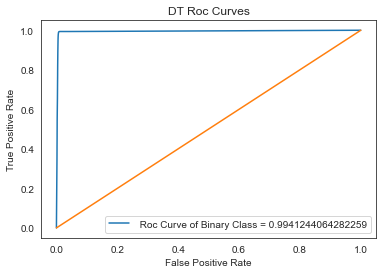

In [23]:
# Concating the list together
dt_Y_test = pd.concat(dt_Y_test_list)
dt_Y_pred = np.concatenate(dt_Y_pred_list)
# Getting the Roc Curve values
test_fpr, test_tpr, test_thresholds = roc_curve(dt_Y_test,dt_Y_pred)
plt.plot(test_fpr, test_tpr, label=" Roc Curve of Binary Class = "+ str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1])
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("DT Roc Curves")
plt.show()